# Synexpression groups identification

ID: 

Name: Iris Milligan

Last modified: 15.11.2020

## Required libraries

In [123]:
import pandas as pd
import scipy
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex, colorConverter
import numpy as np
from scipy import stats
from scipy.signal import find_peaks
from collections import defaultdict
import seaborn as sns
import statsmodels.api as sm
import os
import scipy.cluster.hierarchy as sch
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


## Data import

In [ ]:
# Import external data
# convert data type

    
# import data for analysis
data = pd.read_table("zf10ss.matrix.csv",delimiter = ',')
# set index
data.index = data['gene'] 
data = data.drop(['ENSEMBL','gene','name'], axis=1)

# subset gene
# Drop section 45-96
data = data[data.columns[0:44]]


## Data Preperation for Pearson Correlation


In [ ]:
# Remove Null Records
data=data.dropna()

# Transpose Matrix for processing
dataT=data.T

# Print output to confirm data format
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('transposed_output.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
dataT.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

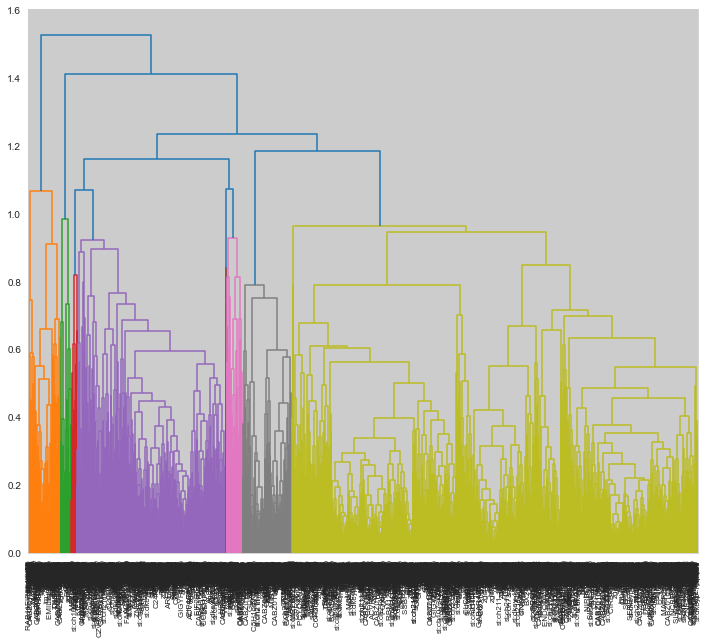

In [126]:
# Define the Pearson Correlation
# pearcorr = dataT.corr('pearson')
from scipy.cluster.hierarchy import cut_tree
pearcorr = pdist(data,'correlation')


# Plot Dendrogram
# Setup Plot Size
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
import seaborn as sns
sns.set_style("whitegrid")

lnk=linkage(pearcorr, metric='correlatin', method='complete')

link_4 = cut_tree(lnk,n_clusters = 4)

pd.crosstab(index=data.index, columns = link_4.T[0],rownames = ['Sec'], colnames = ['ensamble'])
fig, ax = plt.subplots(1,1,figsize = (12,10))

dn = dendrogram(lnk, labels=list(dataT.columns), leaf_font_size = 8, show_leaf_counts = True)
plt.axhline(y=1, c='k', ls='dashed')
plt.show()

In [ ]:
# Function to plot sections of the Dedrogram
def plot_tree(P, pos=None):
    plt.clf()
    icoord = scipy.array(P['icoord'])
    dcoord = scipy.array(P['dcoord'])
    color_list = scipy.array(P['color_list'])
    xmin, xmax = icoord.min(), icoord.max()
    ymin, ymax = dcoord.min(), dcoord.max()
    if pos:
        icoord = icoord[pos]
        dcoord = dcoord[pos]
        color_list = color_list[pos]
    for xs, ys, color in zip(icoord, dcoord, color_list):
        plt.plot(xs, ys, color)
    plt.xlim(xmin-10, xmax + 0.1*abs(xmax))
    plt.ylim(ymin, ymax + 0.1*abs(ymax))
    plt.show()

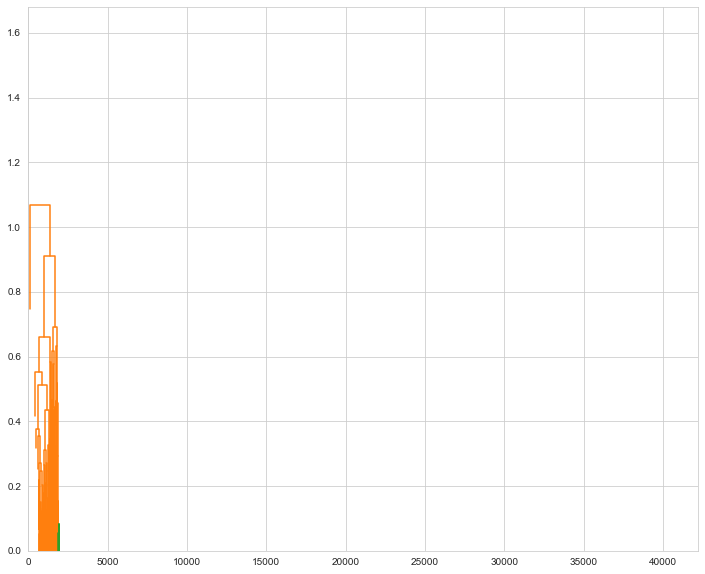

In [128]:
# Plot sub-section
dmin = 0.02
dmax = 0.03
pos = scipy.all((lnk[:,2] >= dmin, lnk[:,2] <= dmax), axis=0).nonzero()

plot_tree( dn, pos )

In [ ]:
ax = sns.heatmap(
    data, 
    vmin=-1, vmax=1, center=0.5,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [129]:
# build class to control clusters
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

# set tick size for readability
def get_clust_graph(df, numclust, transpose=False, dataname=None, save=False, xticksize=8):
    if transpose==True:
        aml=df.transpose()
        xl="x-axis"
    else:
        aml=df
        xl="y-axis"
    data_dist = pdist(aml.transpose(),'correlation') # computing the distance
    data_link = linkage(data_dist,  metric='correlation', method='complete')#method="complete") # computing the linkage
    B=dendrogram(data_link,labels=list(aml.columns),p=numclust, truncate_mode="lastp",get_leaves=True, count_sort='ascending', show_contracted=True)
    #myInd = [i for i, c in zip(B['ivl'], B['color_list']) if c=='g']
    get_cluster_classes(B)
    ax=plt.gca()
    ax.tick_params(axis='x', which='major', labelsize=xticksize)
    ax.tick_params(axis='y', which='major', labelsize=15)
    plt.xlabel(xl)
    #plt.set_size_inches(33.1, 23.4)
    plt.ylabel('Distance')
    plt.suptitle(xl+" clustering for "+dataname, fontweight='bold', fontsize=16);
    if save:
        plt.savefig(str(df.index.name)+str(numclust)+"tr_"+str(transpose)+"dn_"+str(dataname)+save+'.png')
    else:
        print("Not saving")
    return get_cluster_classes(B)

# how to show values in no clusters
def give_cluster_assigns(df, numclust, tranpose=True):
    if transpose==True:
        data_dist = pdist(df.transpose(),'correlation')
        data_link = linkage(data_dist,  metric='correlation', method='complete')
        cluster_assigns=pd.Series(sch.fcluster(data_link, numclust, criterion='maxclust', monocrit=None), index=df.columns)
    else:
        data_dist = pdist(df,'correlation')
        data_link = linkage(data_dist,  metric='correlation', method='complete')
        cluster_assigns=pd.Series(sch.fcluster(data_link, numclust, criterion='maxclust', monocrit=None), index=df.index)
    for i in arange(1,numclust+1):
        print("Cluster ",str(i),": ( N =",len(cluster_assigns[cluster_assigns==i].index),")", ", ".join(list(cluster_assigns[cluster_assigns==i].index)))

In [131]:
# Call plot
get_clust_graph(data, 3837, transpose=True,dataname="Synexpression Groups")

AttributeError: 'numpy.ndarray' object has no attribute 'columns'